<a href="https://colab.research.google.com/github/SantigoD99/colab.ampl.com/blob/master/SBRP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import os

if not os.path.isdir("Data"):
    os.system("git clone https://github.com/SantigoD99/colab.ampl.com")
    os.chdir("colab.ampl.com/authors/SantigoD99/Data")

In [72]:
# Install dependencies
%pip install -q amplpy pandas amplpy-gurobi amplpy-cplex tsplib95 matplotlib

In [73]:
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["coin"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

Using default Community Edition License for Colab. Get yours at: https://ampl.com/ce
Licensed to AMPL Community Edition License for the AMPL Model Colaboratory (https://ampl.com/colab).


In [74]:
import os

USE_CALLBACKS = False # Changed from True to False
PLOTSUBTOURS = True
TSP_FILE = "colegios.tsp"

In [75]:
SOLVER = "gurobi"
SOLVER_OPTIONS = ["outlev=1"]
# Import utilities
from amplpy import AMPL  # pip install amplpy

if SOLVER == "gurobi":
    import amplpy_gurobi as ampls  # pip install amplpy-gurobi
elif SOLVER == "cplex":
    import amplpy_cplex as ampls  # pip install amplpy-cplex
elif SOLVER == "xpress":
    import amplpy_xpress as ampls  # pip install amplpy-gurobi
import tsplib95 as tsp  # pip install tsplib95
import matplotlib.pyplot as plt  # pip install matplotlib
import matplotlib.colors as colors
from time import time
import pandas as pd

plt.rcParams["figure.dpi"] = 200

In [76]:
%%ampl
set NODES ordered;
param hpos {NODES};
param vpos {NODES};

set PAIRS := {i in NODES, j in NODES: ord(i) < ord(j)};

param distance {(i,j) in PAIRS}
   := sqrt((hpos[j]-hpos[i])**2 + (vpos[j]-vpos[i])**2);

var X {PAIRS} binary;

minimize Tour_Length: sum {(i,j) in PAIRS} distance[i,j] * X[i,j];

subject to Visit_All {i in NODES}:
   sum {(i, j) in PAIRS} X[i,j] + sum {(j, i) in PAIRS} X[j,i] = 2;

In [77]:
def getDictFromTspFile(tspFile):
    p = tsp.load(tspFile)
    if not p.is_depictable:
        print("Problem is not depictable!")

    # Amendments as we need the nodes lexographically ordered
    nnodes = len(list(p.get_nodes()))
    i = 0
    while nnodes > 1:
        nnodes = nnodes / 10
        i += 1
    formatString = f"{{:0{i}d}}"
    nodes = {
        formatString.format(value): p.node_coords[index + 1]
        for index, value in enumerate(p.get_nodes())
    }
    return nodes

In [78]:
# Get the model from the cell above
tsp_model = _ampl_cells[0]

# Load model in AMPL
ampl = AMPL()
ampl.eval(tsp_model)
ampl.option["solver"] = SOLVER
ampl.option[SOLVER + "_options"] = " ".join(SOLVER_OPTIONS)

# Set problem data from tsp file
nodes = getDictFromTspFile(TSP_FILE)
df = pd.DataFrame.from_dict(nodes, orient="index", columns=["hpos", "vpos"])
df.index.name = "NODES"
ampl.set_data(df, "NODES")

# Set some globals that never change during the execution of the problem
NODES = set(nodes.keys())
CPOINTS = {
    node: complex(coordinate[0], coordinate[1]) for (node, coordinate) in nodes.items()
}

In [79]:
def plotTours(tours: list, points_coordinate: dict):
    # Plot all the tours in the list each with a different color
    colors = ["b", "g", "c", "m", "y", "k"]
    for i, tour in enumerate(tours):
        tourCoordinates = [points_coordinate[point.strip("'")] for point in tour]
        color = colors[i % len(colors)]
        plot_all(tourCoordinates, color=color)
    plt.show()


def plot_all(tour, alpha=1, color=None):
    # Plot the tour as blue lines between blue circles
    plotline(list(tour) + [tour[0]], alpha=alpha, color=color)
    plotline([tour[0]], "s", alpha=alpha, color=color)


def plotline(points, style="o-", alpha=1, color=None):
    "Plot a list of points (complex numbers) in the 2-D plane."
    X, Y = XY(points)
    if color:
        plt.plot(X, Y, style, alpha=alpha, color=color)
    else:
        plt.plot(X, Y, style, alpha=alpha)


def XY(points):
    "Given a list of points, return two lists: X coordinates, and Y coordinates."
    return [p.real for p in points], [p.imag for p in points]

In [80]:
# Graphs helper routines
def trasverse(node, arcs: set, allnodes: set, subtour=None) -> list:
    # Trasverses all the arcs in the set arcs, starting from node
    # and returns the tour
    if not subtour:
        subtour = list()
    # Find arcs involving the current node
    myarcs = [(i, j) for (i, j) in arcs if node == i or node == j]
    if len(myarcs) == 0:
        return
    # Append the current node to the current subtour
    subtour.append(node)

    # Use the first arc found
    myarc = myarcs[0]
    # Find destination (or origin) node
    destination = next(i for i in myarc if i != node)
    # Remove from arcs and nodes to visit
    arcs.remove(myarc)
    if node in allnodes:
        allnodes.remove(node)

    trasverse(destination, arcs, allnodes, subtour)
    return subtour


def findSubTours(arcs: set, allnodes: set):
    """Find all the subtours defined by a set of arcs and
    return them as a list of list
    """
    subtours = list()
    allnodes = allnodes.copy()
    while len(allnodes) > 0:
        l = trasverse(next(iter(allnodes)), arcs, allnodes)
        subtours.append(l)
    return subtours

In [81]:
def amplSubTourElimination(ampl: AMPL):
    # Add the constraint and the needed parameters
    subToursAMPL = """param nSubtours >= 0 integer, default 0;
    set SUB {1..nSubtours} within NODES;

    subject to Subtour_Elimination {k in 1..nSubtours}:
    sum {i in SUB[k], j in NODES diff SUB[k]}
    if (i, j) in PAIRS then X[i, j] else X[j, i] >= 2;"""
    ampl.eval(subToursAMPL)

    nSubtoursParam = ampl.get_parameter("nSubtours")
    SubtoursSet = ampl.get_set("SUB")

    allsubtours = list()
    while True:  # Repeat until the solution contains only one tour
        ampl.solve()
        assert ampl.solve_result == "solved"
        # Get solution
        ARCS = ampl.get_data("{(i,j) in PAIRS : X[i,j] > 0} X[i,j];")
        ARCS = set([(i, j) for (i, j, k) in ARCS.toList()])
        subtours = findSubTours(ARCS, NODES)
        # If we have only one tour, the solution is valid
        if len(subtours) <= 1:
            break
        print(f"Found {len(subtours)} subtours, plotting them and adding cuts")
        if PLOTSUBTOURS:
            plotTours(subtours, CPOINTS)
        # Else add the current tours to the list of subtours
        allsubtours.extend(subtours)
        # And add those to the constraints by assigning the values to
        # the parameter and the set
        nSubtoursParam.set(len(allsubtours))
        for i, tour in enumerate(allsubtours):
            SubtoursSet[i + 1].set_values(tour)

In [82]:
# Callback class that actually add the cuts if subtours are found in a solution
class MyCallback(ampls.GenericCallback):
    def __init__(self):
        # Constructor, simply sets the iteration number to 0
        super().__init__()
        self.iteration = 0

    def run(self):
        try:
            # For each solution
            if self.getAMPLWhere() == ampls.Where.MIPSOL:
                self.iteration += 1
                print(f"\nIteration {self.iteration}: Finding subtours")
                sol = self.getSolutionVector()
                arcs = [xvars[i] for i, value in enumerate(sol) if value > 0]
                subTours = findSubTours(set(arcs), set(vertices))
                if len(subTours) == 1:
                    print("No subtours detected. Not adding any cut")
                    return 0
                print(f"Adding {len(subTours)} cuts")
                if PLOTSUBTOURS:
                    plotTours(subTours, CPOINTS)
                for subTour in subTours:
                    st1 = set(subTour)
                    nst1 = set(vertices) - st1
                    externalArcs = [
                        (i, j) if i < j else (j, i) for i in st1 for j in nst1
                    ]
                    varsExternalArcs = [xinverse[i, j] for (i, j) in externalArcs]
                    coeffs = [1 for i in range(len(varsExternalArcs))]
                    if PLOTSUBTOURS:
                        print("Adding cut for subtour:", st1)
                    self.addLazyIndices(
                        varsExternalArcs, coeffs, ampls.CutDirection.GE, 2
                    )
                    if len(subTours) == 2:
                        return 0
                print("Continue solving")
            return 0
        except Exception as e:
            print("Error:", e)
            return 1

In [83]:
# Global variables to store entities needed by the callbacks
# that never change
xvars = None
xinverse = None
vertices = None


def solverSubTourElimination(ampl: AMPL, solver, solver_options):
    global xvars, xinverse, vertices
    # Export the model using ampls
    model = ampl.to_ampls(solver, solver_options)
    model.enableLazyConstraints()

    # Get the global maps between solver vars and AMPL entities
    varMap = model.getVarMapFiltered("X")
    # print("varMap:", varMap)
    inverse = model.getVarMapInverse()
    xvars = {index: ampls.var2tuple(var)[1:] for var, index in varMap.items()}
    xinverse = {ampls.var2tuple(var)[1:]: index for index, var in inverse.items()}
    vertices = list(
        sorted(set([x[0] for x in xvars.values()] + [x[1] for x in xvars.values()]))
    )

    # Assign the callback
    callback = MyCallback()
    model.set_callback(callback)
    print("Start optimization")
    # Start the optimization
    model.optimize()
    # Import the solution back to AMPL
    ampl.import_ampls_solution(model)

Gurobi 12.0.2: Set parameter LogToConsole to value 1
  tech:outlev = 1

AMPL MP initial flat model has 171 variables (0 integer, 171 binary);
Objectives: 1 linear; 
Constraints:  19 linear;

AMPL MP final model has 171 variables (0 integer, 171 binary);
Objectives: 1 linear; 
Constraints:  19 linear;


Set parameter InfUnbdInfo to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
InfUnbdInfo  1

Optimize a model with 19 rows, 171 columns and 342 nonzeros
Model fingerprint: 0x93782e9f
Variable types: 0 continuous, 171 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 39801.666619
Presolve time: 0.01s
Presolved: 

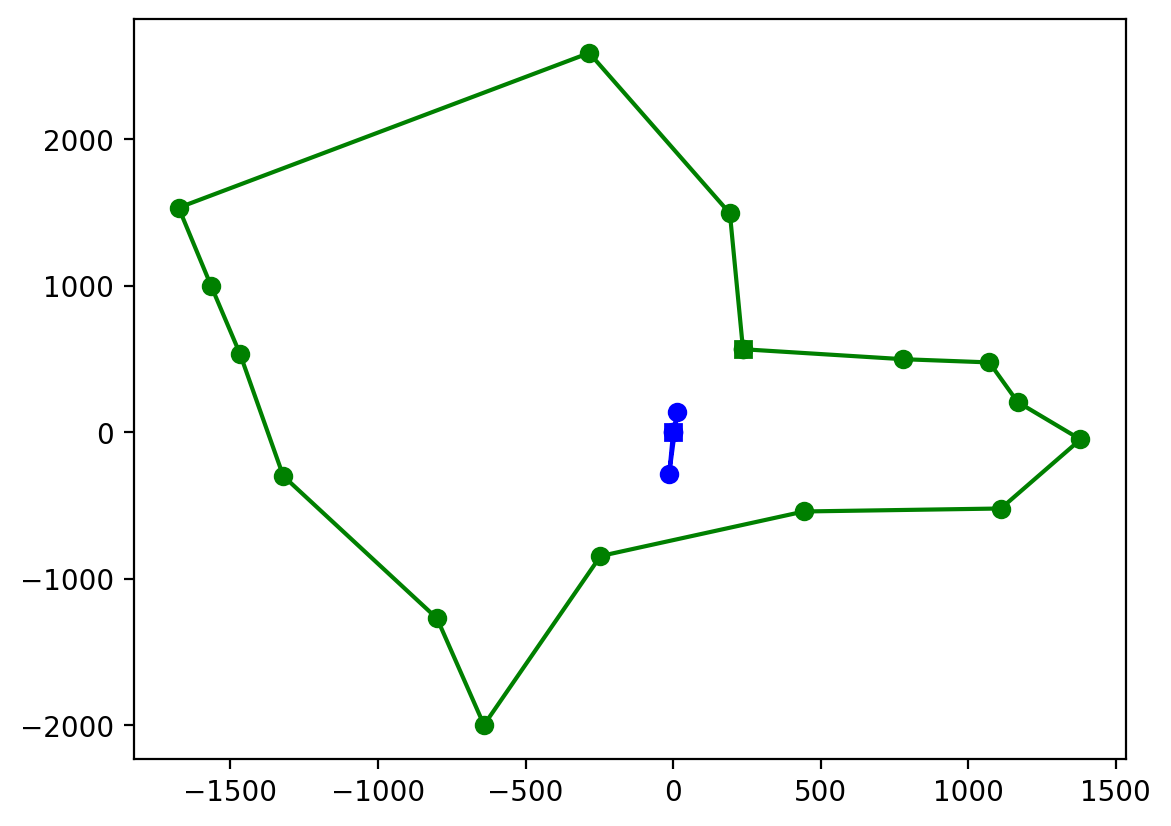

Gurobi 12.0.2: Set parameter LogToConsole to value 1
  tech:outlev = 1

AMPL MP initial flat model has 171 variables (0 integer, 171 binary);
Objectives: 1 linear; 
Constraints:  21 linear;

AMPL MP final model has 171 variables (0 integer, 171 binary);
Objectives: 1 linear; 
Constraints:  21 linear;


Set parameter InfUnbdInfo to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
InfUnbdInfo  1

Optimize a model with 21 rows, 171 columns and 438 nonzeros
Model fingerprint: 0x44514812
Variable types: 0 continuous, 171 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]

User MIP start did not produce a new incumbent solution
User MIP start violates 

In [84]:
t0 = time()
if not USE_CALLBACKS:
    amplSubTourElimination(ampl)
else:
    solverSubTourElimination(ampl, SOLVER, SOLVER_OPTIONS)